In [13]:
from google.colab import drive
drive.mount('/content/gdrive')
#!cp gdrive/My\ Drive/Tesis_Resources/blured.png .
#!cp gdrive/My\ Drive/Tesis_Resources/blured1.png .
#!cp gdrive/My\ Drive/Tesis_Resources/deblured.png .
#!cp gdrive/My\ Drive/Tesis_Resources/deblured1.png .

!cp gdrive/My\ Drive/Tesis_Resources/yolo/yolo.zip .
!unzip yolo.zip
!cp gdrive/My\ Drive/Tesis_Resources/kaggle.json .

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  yolo.zip
   creating: config/
  inflating: config/coco.data        
  inflating: config/coco.names       
  inflating: config/download_weights.sh  
  inflating: config/yolov3-tiny.cfg  
  inflating: config/yolov3.cfg       
  inflating: config/yolov3.weights   
   creating: images/
  inflating: images/blueangels-det.jpg  
  inflating: images/blueangels.jpg   
  inflating: images/Intersection-Counts.jpg  
  inflating: images/olympic-trials.jpg  
   creating: utils/
  inflating: utils/datasets.py       
  inflating: utils/parse_config.py   
  inflating: utils/utils.py          
   creating: utils/__pycache__/
  inflating: utils/__pycache__/datasets.cpython-36.pyc  
  inflating: utils/__pycache__/parse_config.cpython-36.pyc  
  inflating: utils/__pycache__/utils.cpython-36.pyc  
  inflating: utils/__pycache__/__init__.cpython-36.pyc  
  inflating: mo

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json
!pip install -q kaggle
!pip install -q kaggle-cli

kaggle.json


total 4
-rw------- 1 root root 63 Jul 10 03:06 kaggle.json
     |████████████████████████████████| 81kB 18.6MB/s 
     |████████████████████████████████| 5.3MB 46.3MB/s 
     |████████████████████████████████| 112kB 62.6MB/s 
     |████████████████████████████████| 102kB 35.0MB/s 
     |████████████████████████████████| 51kB 24.4MB/s 


In [8]:
!kaggle datasets download -d smeschke/pedestrian-dataset  -p /content/gdrive/My\ Drive/Tesis_Resources
#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/gdrive/My\ Drive/Chest_Xray


 70% 34.0M/48.8M [00:01<00:00, 18.5MB/s]
100% 48.8M/48.8M [00:01<00:00, 38.9MB/s]


In [10]:
!cp gdrive/My\ Drive/Tesis_Resources/pedestrian-dataset.zip .
!unzip pedestrian-dataset.zip

Archive:  pedestrian-dataset.zip
  inflating: night.avi               
  inflating: night.csv               
  inflating: fourway.csv             
  inflating: crosswalk.avi           
  inflating: fourway.avi             
  inflating: crosswalk.csv           


In [0]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [0]:
import cv2
vidcap = cv2.VideoCapture('crosswalk.avi')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  count += 1

In [16]:
vidcap.get(cv2.CAP_PROP_POS_FRAMES)

378.0

In [20]:
vidcap.get(cv2.CAP_PROP_POS_MSEC) / 1000

12.6

In [21]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size=416 #416
conf_thres=0.4
nms_thres=0.1

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
#print(model)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor 

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [0]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
        print(detections[0])
    return detections[0]

tensor([[210.1713, 114.9686, 402.8210, 285.7736,   0.8295,   0.9299,  39.0000]],
       device='cuda:0')
Inference Time: 0:00:00.076857
número de detecciones 1
unique_labels
tensor([39.])
n_cls_preds
1
detections tensor([[210.1713, 114.9686, 402.8210, 285.7736,   0.8295,   0.9299,  39.0000]],
       device='cuda:0')
color
(0.807843137254902, 0.8588235294117647, 0.611764705882353, 1.0)


<Figure size 432x288 with 0 Axes>

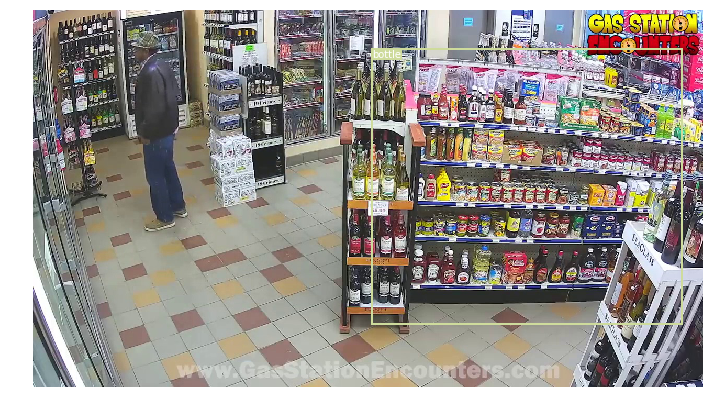

In [27]:
# load image and get detections
img_path = "frame100.jpg"
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x
print('número de detecciones ' + str(len(detections)))

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    print('unique_labels')
    print(unique_labels)
    n_cls_preds = len(unique_labels)
    print('n_cls_preds')
    print(n_cls_preds)
    bbox_colors = random.sample(colors, n_cls_preds)
    print('detections', detections)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        print('color')
        print(color)
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
plt.savefig(img_path.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()